# Getting Started

To run this notebook you will first need to download the GW data,

`python download_SXSwaveform_data.py`

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import WDM
from WDM.code.utils.utils import next_multiple

Here's an example GW waveform. We also compute the frequency of the signal as a function of time.

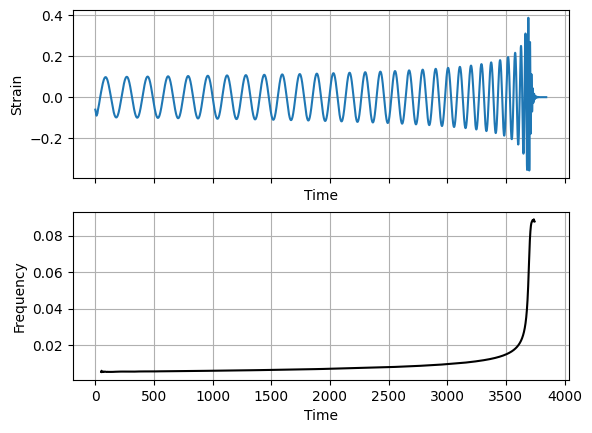

In [57]:
data = np.loadtxt("../data/waveform_SXS:BBH:0305_Reh22.txt")

time = data[0]
re_strain = data[1]
im_strain = data[2]

frequency = np.diff(-np.unwrap(np.atan2(im_strain, re_strain)), prepend=0) / np.diff(time, prepend=0) / (2*np.pi)

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(time, re_strain)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Strain')
axes[0].grid()
axes[1].plot(time[100:-200], frequency[100:-200], 'k-')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].grid()
plt.show()

In [58]:
current_length = len(time)

print(f"Current length of time series: {current_length}")

Current length of time series: 7688


Let's take a wavelet transform of this using $N_f=512$ frequency slices. 
The `wdm` object will handle the wavelet transform.
We need to pad the signal so that it's length is an even multiple of this number

In [59]:
dt = np.mean(np.diff(time))

Nf = 512

N = next_multiple(current_length, 2*Nf)

wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=dt, Nf=Nf, N=N, q=8, calc_m0=True)

re_strain_padded, mask = wdm.pad_signal(re_strain)

print(f"Padded length of time series: {N}")


Padded length of time series: 8192


Take the forward discrete wavelet transform (dwt). This transforms from the time domain to the time-frequency domain.

In [69]:
w = wdm.dwt(re_strain_padded)



We can plot these coefficients in the time-frequency plane. 
The black line shows the frequency obtained directly from the NR waveform.
Note, this doesn't look as beautifully smooth as the oversampled periodograms we are used to looking at, but this is what we want for data analysis.

In [62]:
fig, ax = wdm.time_frequency_plot(w, part='abs', scale='linear')
ax.set_ylim(0,0.1)
ax.plot(time[100:-200], frequency[100:-200], color='k', lw=2)
plt.show()

AttributeError: 'int' object has no attribute 'shape'

Let's take an inverse discrete wavelet transform (idwt). 

This transforms back into the time domain.
We do this to check we can recover the original signal.
We will use the mask to get the output back to the original shape.

In [ ]:
re_strain_recovered = wdm.idwt(w)[mask]

residuals = re_strain_recovered-re_strain

print(f"Max residual: {np.max(np.abs(residuals))}")

Max residual: 0.0010781081917313265


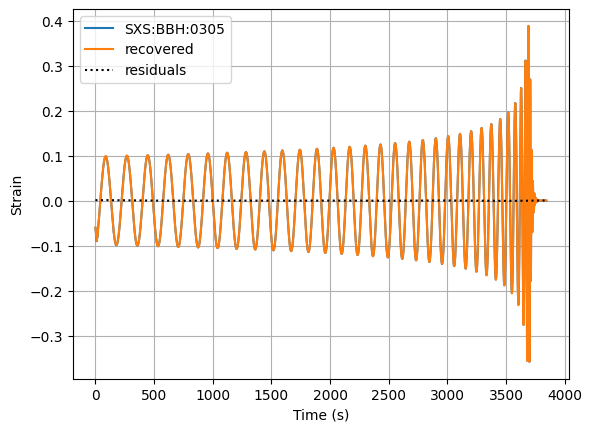

In [ ]:
fig, ax = plt.subplots()
ax.plot(time, re_strain, label='SXS:BBH:0305')
ax.plot(time, re_strain_recovered, label='recovered')
ax.plot(time, residuals, 'k:', label='residuals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain')
ax.legend()
ax.grid()
plt.show()